In [1]:
import pandas as pd
import numpy as np
from os.path import join
import joblib
from glob import glob
import sys
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
import skexplain
import shap
#from display_names import to_readable_names, get_units

In [2]:
#feature_names = X.columns
#display_feature_names = {f : to_readable_names(f) for f in feature_names}
#display_units = {f : get_units(f) for f in feature_names}

#display_feature_names = {**display_feature_names, **FIGURE_MAPPINGS}
#display_units = {**display_units, **UNITS }

In [3]:
hazard = 'severe_wind'

print(f'Loading data...') 
base_path = '/work/mflora/ML_DATA/DATA'
data_path = join(base_path, f'original_first_hour_training_matched_to_{hazard}_0km_data.feather')
train_df = pd.read_feather(data_path)

Loading data...


In [4]:
def name_mapping(previous_feature_names):
    """
    The goal of this new method is to convert feature names 
    saved with the ML model into the new feature names.
    """
    corrected_feature_names={}
    for f in previous_feature_names:
        if 'mb' in f and 'temperature' in f:
            new_f = f.replace('mb','')
        elif 'dewpoint' in f and 'mb' in f:
            new_f = f.replace('mb','').replace('dewpoint', 'td')
        elif 'geopotential' in f:
            new_f =f.replace('geopotential_height','geo_hgt').replace('mb', '')
        elif 'cloud_top_temp' in f:
            new_f =f.replace('cloud_top_temp','ctt')
        elif 'divergence' in f:
            new_f =f.replace('divergence_10m','div_10m')
        elif '10-m_bulk_shear' in f:
            new_f =f.replace('10-m_bulk_shear','10-500m_bulkshear')
        elif 'th_e_ml' in f:
            new_f =f.replace('th_e_ml','theta_e')
        elif '1to3km' in f or '3to5km' in f:
            new_f =f.replace('km_max','')
        elif 'bouyancy' in f:
            # Spelling error!
            new_f = f.replace('bouyancy','buoyancy')
        else:
            new_f = f
        
        # Additional '_' in the new format! 
        new_f = new_f.replace('_ens_mean', '__ens_mean')
        new_f = new_f.replace('_ens_std', '__ens_std')
        new_f = new_f.replace('_spatial_mean', '__spatial_mean')
        new_f = new_f.replace('_time_max', '__time_max')
        new_f = new_f.replace('_time_min', '__time_min')
        
        # New naming convention for amplitude stats! 
        new_f = new_f.replace('_ens_std_of_90th', '_amp_ens_std')
        new_f = new_f.replace('_ens_mean_of_90th', '_amp_ens_mean')
        new_f = new_f.replace('_ens_std_of_10th', '_amp_ens_std')
        new_f = new_f.replace('_ens_mean_of_10th', '_amp_ens_mean')
        
        #Baseline var
        #new_f = new_f.replace('uh_probs_>180_prob_max', 'uh_nmep_>180_3km__prob_max')
        #new_f = new_f.replace('hail_probs_>1.0_prob_max', 'hail_nmep_>1.0_3km__prob_max')
        #new_f = new_f.replace('wind_probs_>40_prob_max', 'wnd_nmep_>40_3km__prob_max')
        
        corrected_feature_names[f] = new_f

    return corrected_feature_names

In [5]:
hazard = 'severe_wind'

base_path = '/work/mflora/ML_DATA/MODEL_SAVES'
model_name = 'LogisticRegression'
model_paths = glob(join(base_path, f'{model_name}_first_hour_{hazard}*'))
model_path = [m for m in model_paths if 'manual' not in m][0]
model_data = joblib.load(model_path)

model = model_data['model']
feature_names = model_data['features']

In [6]:
path = 'https://storwofstest003.blob.core.windows.net/post/WOFSRun20220404-152140/20220404/2300/'

# wofs_MLDATA_14_20220404_2340_0010.feather
# wofs_MLDATA_15_20220404_2345_0015.feather
# wofs_MLDATA_16_20220404_2350_0020.feather
# wofs_MLDATA_17_20220404_2355_0025.feather
# wofs_MLDATA_18_20220404_0000_0030.feather
df = pd.read_feather(join(path, 'wofs_MLDATA_17_20220404_2355_0025.feather'))

In [7]:
mapper = name_mapping(feature_names)
names_converted = [mapper.get(f,f) for f in feature_names]

In [8]:
X = df[names_converted]
pred = model.predict_proba(X)[:,1]
ind = np.argmax(pred)

In [9]:
np.max(pred)

0.5276653171390012

In [10]:
X_train = train_df[feature_names].astype(float)
inds = np.random.choice(len(X_train), size=5000, replace=False)
X_train = X_train.iloc[inds, :]
X_train.reset_index(drop=True, inplace=True)

In [11]:
explainer = skexplain.ExplainToolkit(('LR', model), X=X.iloc[[ind],:],)

In [12]:
shap_ds = explainer.local_contributions(method='shap', 
                                        shap_kwargs={'masker' : 
                                          shap.maskers.Partition(X_train, 
                                                                 max_samples=1000, clustering="correlation"), 
                                             'algorithm' : 'permutation'})

In [13]:
reverse_mapper = {v: k for k, v in mapper.items()}

In [14]:
sys.path.append('/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/explain')
from display_names import to_readable_names, get_units

feature_names = X.columns
display_feature_names = {f : to_readable_names(reverse_mapper[f]) for f in feature_names}
display_units = {f : get_units(reverse_mapper[f]) for f in feature_names}

(<Figure size 2400x1950 with 3 Axes>, <AxesSubplot:>)

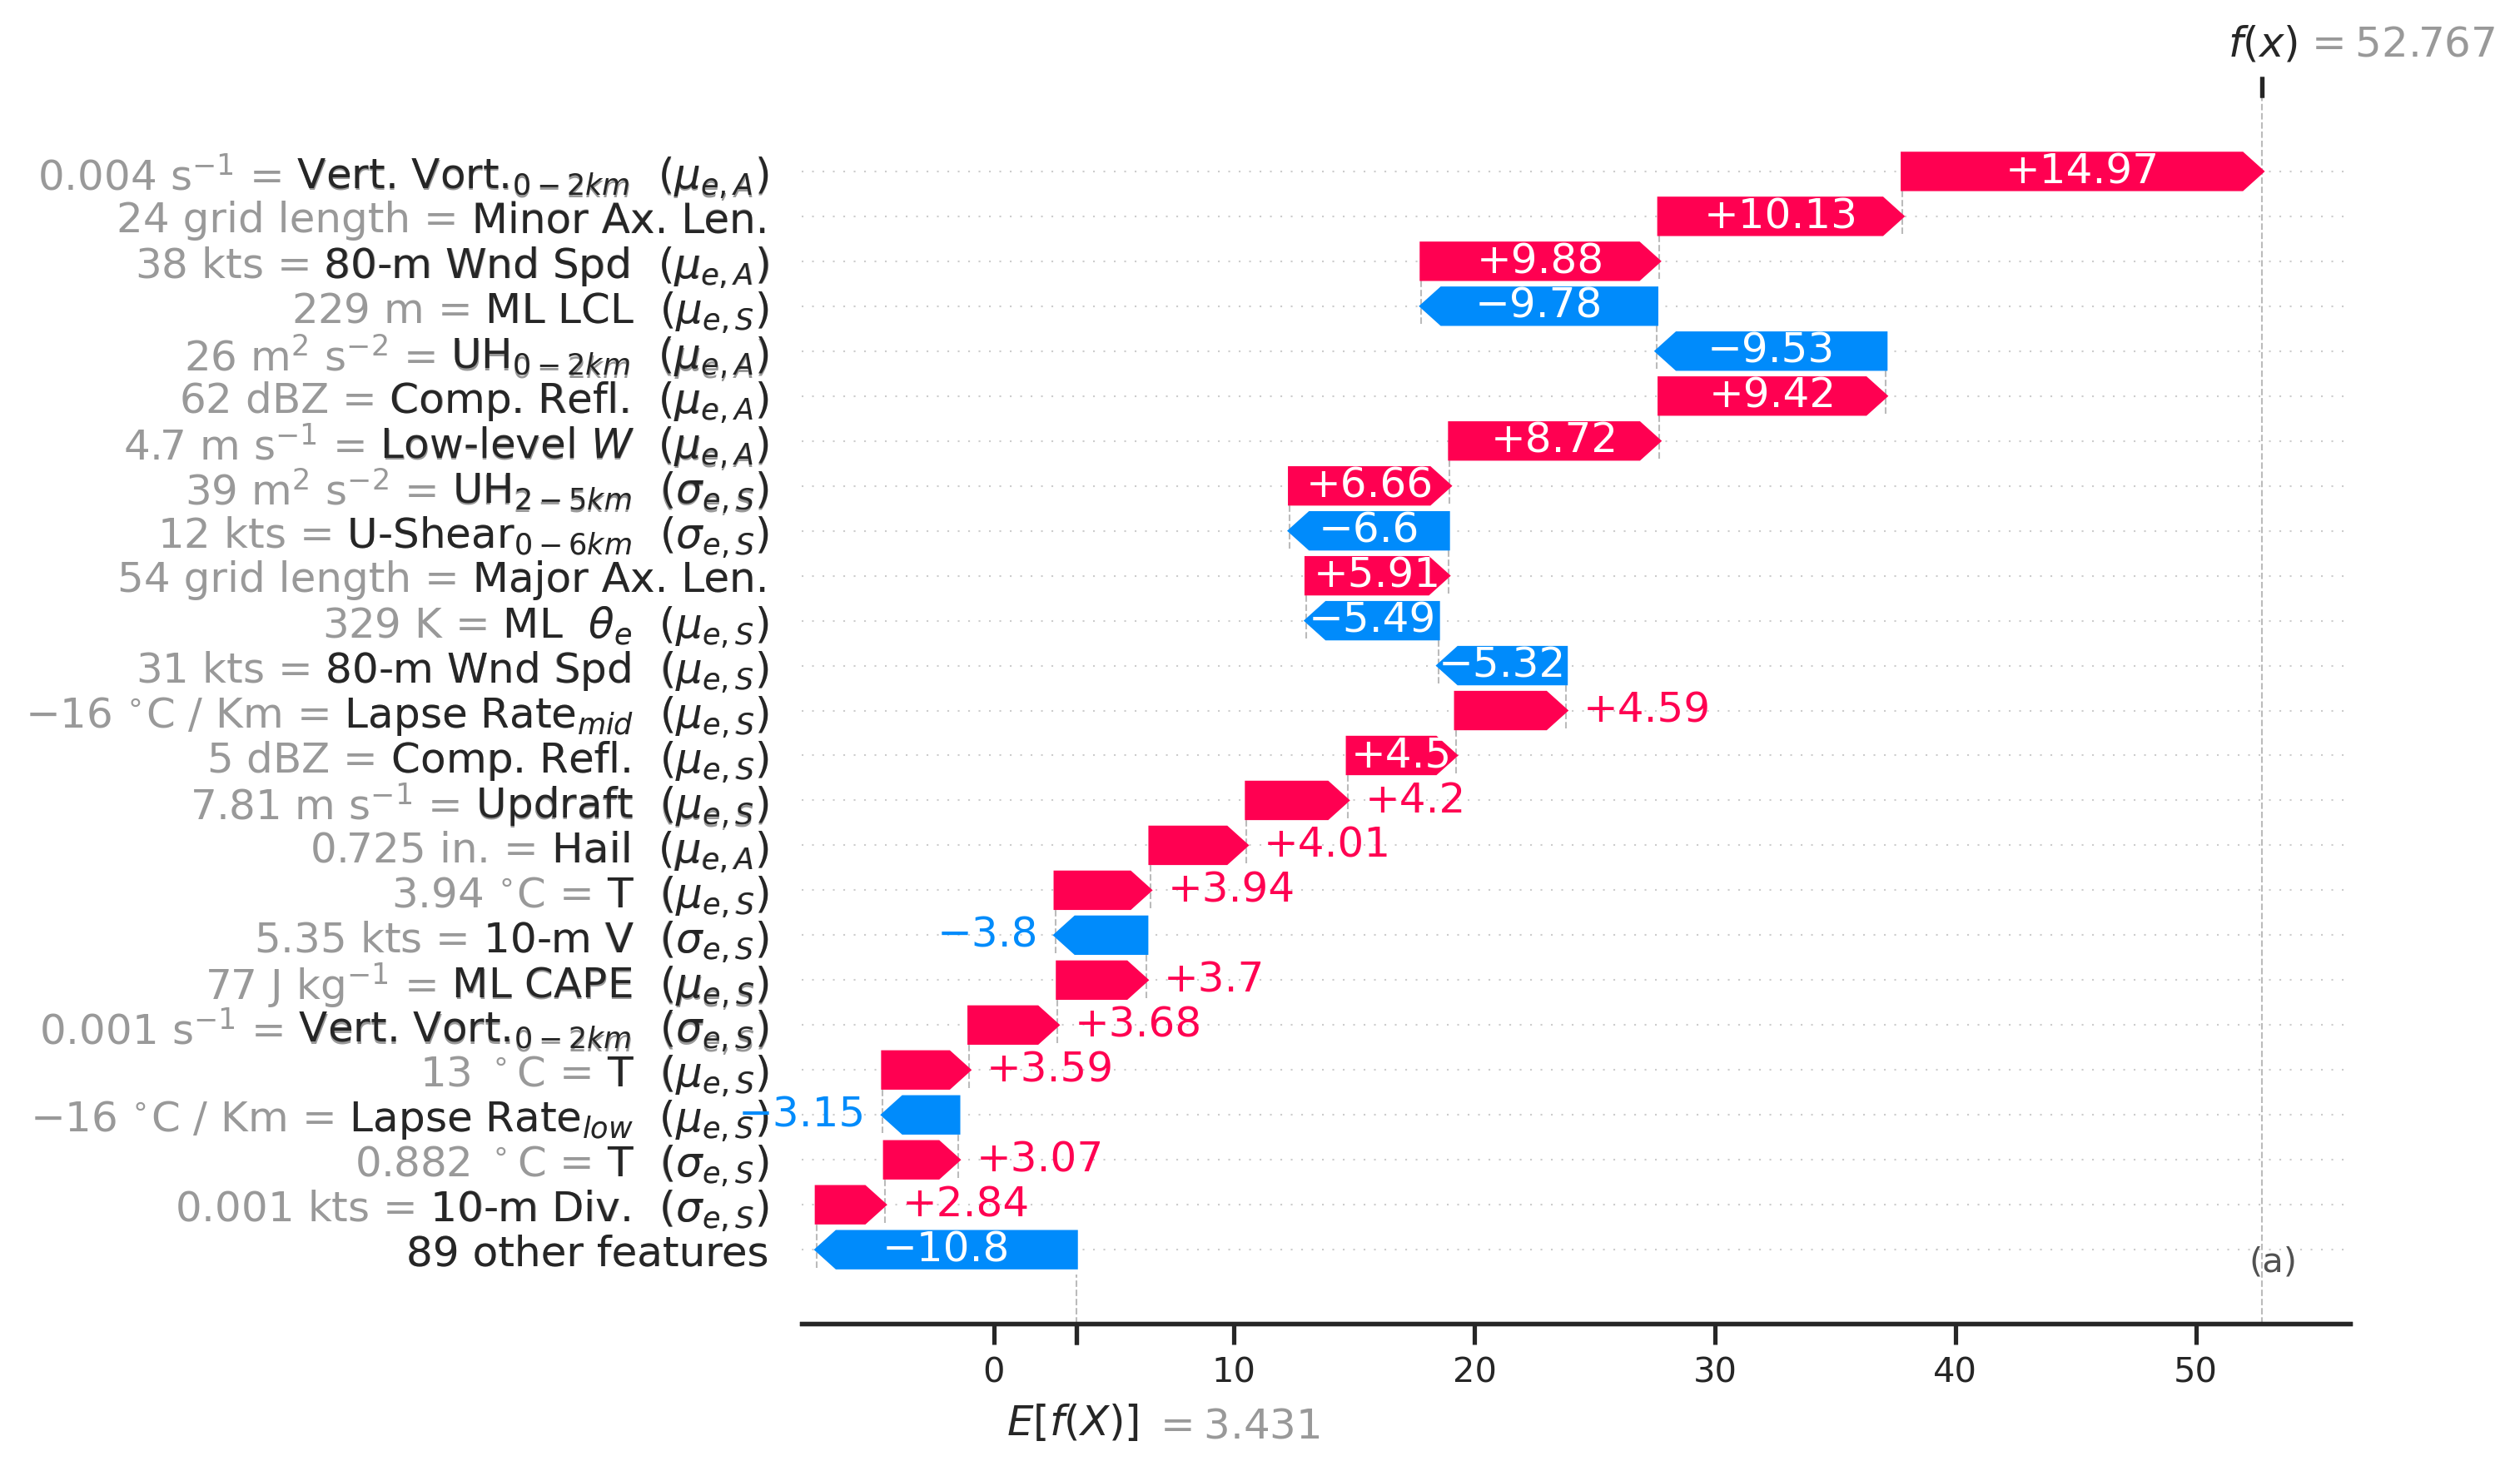

In [15]:
explainer.plot_contributions(
                           contrib=shap_ds,
                           max_display=25,
                           display_feature_names = display_feature_names,
                            display_units = display_units, 
                                )

In [16]:
list(shap_ds.columns)

['srh_0to1__ens_mean__spatial_mean_contrib',
 'srh_0to3__ens_mean__spatial_mean_contrib',
 'cape_ml__ens_mean__spatial_mean_contrib',
 'cin_ml__ens_mean__spatial_mean_contrib',
 'shear_u_0to6__ens_mean__spatial_mean_contrib',
 'shear_v_0to6__ens_mean__spatial_mean_contrib',
 'shear_u_0to1__ens_mean__spatial_mean_contrib',
 'shear_v_0to1__ens_mean__spatial_mean_contrib',
 'lcl_ml__ens_mean__spatial_mean_contrib',
 'theta_e__ens_mean__spatial_mean_contrib',
 'u_10__ens_mean__spatial_mean_contrib',
 'v_10__ens_mean__spatial_mean_contrib',
 'mid_level_lapse_rate__ens_mean__spatial_mean_contrib',
 'low_level_lapse_rate__ens_mean__spatial_mean_contrib',
 'temperature_850__ens_mean__spatial_mean_contrib',
 'temperature_700__ens_mean__spatial_mean_contrib',
 'temperature_500__ens_mean__spatial_mean_contrib',
 'geo_hgt_850__ens_mean__spatial_mean_contrib',
 'geo_hgt_700__ens_mean__spatial_mean_contrib',
 'geo_hgt_500__ens_mean__spatial_mean_contrib',
 'td_850__ens_mean__spatial_mean_contrib',
 

In [17]:
shap_ds['ws_80__time_max__amp_ens_mean_val']

non_performance  LR    38.107845
Name: ws_80__time_max__amp_ens_mean_val, dtype: float64

In [18]:
shap_ds['comp_dz__time_max__amp_ens_mean_val']

non_performance  LR    61.567654
Name: comp_dz__time_max__amp_ens_mean_val, dtype: float64